In [1]:
import cv2
import numpy as np
import math
import imutils
from matplotlib import pyplot as plt
from ponyslayer.utils import imshow, imshows, imdraw, imdraws, imdraws_color, immask, immasks, implot, imsave
from ponyslayer import unicorn, transform, chessboard_detection
from Kmean_BG_segment import segment

Parameter Setup

In [2]:
image_resolution = 800 # [pixel] Image ratio can be only 1:1
image_size = 400 # [mm.]
marker_size = 60 # [mm.]
marker_size_error = 0.15 # [ratio] Allowable card size error
min_path_length = 30 # [mm.]
max_path_length = 999 # [mm.]
min_path_width = 5 # [mm.]
max_path_width = marker_size + (marker_size*marker_size_error) # [mm.]
gradient_crop_ratio = 0.9 # Exclude both end (prevent too width range from noise)
min_height = 10
max_height = 20
min_intensity_range = 15 # ช่วงของ intensity ที่แคบที่สุดที่ยังถือว่าเป็น gradient

Filter Setup

In [3]:
UnsharpMaskBeforeFindMarker = True
BlurKernelSize = (3, 3)

Load Image

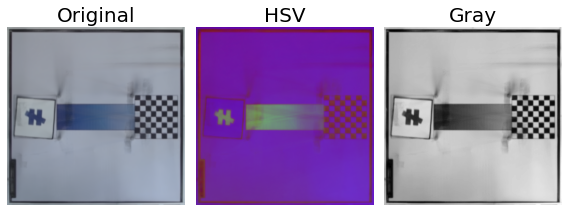

In [4]:
marker = cv2.imread("../img/StartReal1.png")
frame = cv2.imread("X:/final/Median with valid mask.png")
frame = cv2.imread("../img/Real7.png")
original = frame.copy()
gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
gray_blurred = cv2.GaussianBlur(gray, BlurKernelSize, 0)
HSV = cv2.cvtColor(frame, cv2.COLOR_BGR2HSV)
imshows([cv2.cvtColor(original, cv2.COLOR_BGR2RGB), HSV, gray], ["Original", 'HSV', 'Gray'])
gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

None


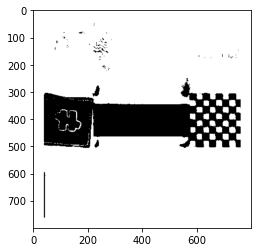

In [5]:
import DBSCAN
mask = DBSCAN.cluster(frame, esp_value=0.7, scale=2, N=1000)
# mask = cv2.imread("X:/segment.png", 0)
imshow(mask)

In [6]:
# H, S, V = cv2.split(HSV)
# imshows([H, S, V], ['H', 'S', 'V'])
# %matplotlib inline
# from ipywidgets import interact, widgets
# def inrange(low_H, high_H, low_S, high_S, low_V, high_V):
#     filtered = cv2.inRange(HSV, (low_H, low_S, low_V), (high_H, high_S, high_V))
#     imshow(filtered)
# interact(inrange, low_H=widgets.IntSlider(min=0,max=255,step=1,value=0),
#          high_H=widgets.IntSlider(min=0,max=255,step=1,value=255),
#          low_S=widgets.IntSlider(min=0,max=255,step=1,value=0),
#          high_S=widgets.IntSlider(min=0,max=255,step=1,value=255),
#          low_V=widgets.IntSlider(min=0,max=255,step=1,value=0),
#          high_V=widgets.IntSlider(min=0,max=255,step=1,value=255),);

(432657760.0, (572, 304), 1.0)
(10161347.0, (41, 323), 1.0)


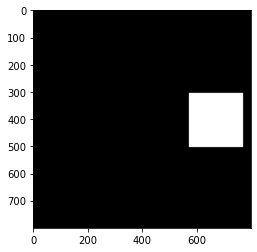

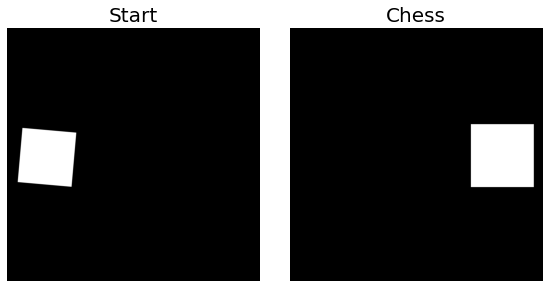

In [7]:
from ponyslayer import search_chess, search_marker
chess_mask, chess_center = search_chess.run(mask)
imshow(chess_mask)
start_mask, start_center = search_marker.run(frame, marker)
imshows([start_mask, chess_mask], ["Start", "Chess"])
# black_obj_mask = cv2.inRange(HSV, (0, 0, 0), (255, 255, 70))
# imshow(black_obj_mask)

Remove all Markers

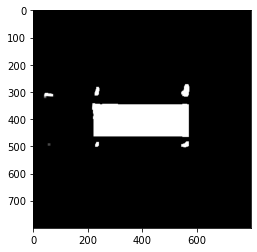

Path count: 1


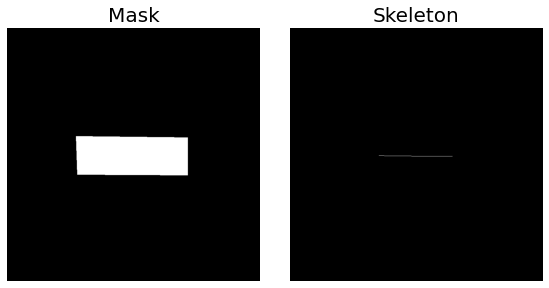

In [8]:
path_mask = cv2.bitwise_or(mask, chess_mask)
path_mask = cv2.bitwise_or(path_mask, start_mask)
path_mask = cv2.bitwise_not(path_mask)
path_mask_opening = cv2.morphologyEx(path_mask, cv2.MORPH_OPEN, np.ones((9, 9)))
imshow(path_mask_opening)
contours,hierarchy = cv2.findContours(path_mask_opening, cv2.RETR_TREE,cv2.CHAIN_APPROX_SIMPLE)

path_contours = []
for cnt in contours:
    area = cv2.contourArea(cnt)
    poly_points = cv2.approxPolyDP(cnt, 0.02 * frame.shape[0], False) # approximate polygon
    m = immask(poly_points, np.zeros_like(frame))
    # imshow(m)
    if area > 20000: path_contours.append(poly_points)
print("Path count: " + str(len(path_contours)))
from skimage.morphology import skeletonize
from skimage import data
from skimage.util import invert
from scipy.ndimage import generic_filter
path_masks = [immask(cnt, frame) for cnt in path_contours]
path_skeletons = []
for i in range(len(path_masks)):
    mask_erode = path_masks[i]
    while True:
        eroded = cv2.erode(mask_erode, np.ones((5, 5)), iterations=1)
        contours,_ = cv2.findContours(eroded, cv2.RETR_TREE,cv2.CHAIN_APPROX_SIMPLE)
        if len(contours) == 1: mask_erode = eroded
        else: break
    skeleton = skeletonize(mask_erode, method='lee')
    path_skeletons.append(skeleton)
    imshows([path_masks[i], skeleton], ['Mask', 'Skeleton'])

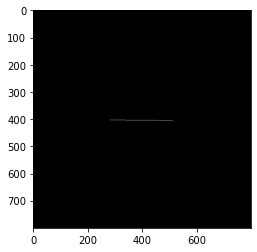

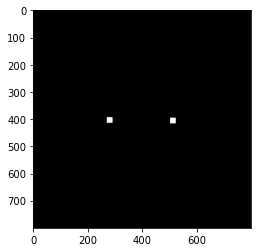

In [9]:
# Line ends filter
def lineEnds(P):
    """Central pixel and just one other must be set to be a line end"""
    return 255 * ((P[4]==255) and np.sum(P)==510)
end_points = []
path_cnts = []
path_cnts_approx = []
for skeleton in path_skeletons:
    points = np.column_stack(np.where(skeleton.transpose() != 0)) # get array of points
    poly_points = cv2.approxPolyDP(points, 0.02 * frame.shape[0], False) # approximate polygon
    poly_canvas = np.zeros_like(original, np.uint8)
    cv2.polylines(poly_canvas, [poly_points], False, (255,255,255), 1)
    imshow(poly_canvas)

    end_of_line = generic_filter(skeleton, lineEnds, (3, 3)) # find end of line
    imshow(cv2.dilate(end_of_line,np.ones((3, 3)),iterations = 10))
    end_points.append(np.where(end_of_line==255))

    path_cnts.append(points)
    path_cnts_approx.append(poly_points)

## Generate 2D Waypoints and Extract Gradient

[(281, 403, 10), (282, 403, 10), (283, 403, 10), (284, 403, 10), (285, 403, 10), (286, 403, 10), (287, 403, 10), (288, 403, 10), (289, 403, 10), (290, 403, 10), (291, 403, 10), (292, 403, 10), (293, 403, 10.444444444444445), (294, 403, 10.88888888888889), (295, 403, 11.11111111111111), (296, 403, 11.333333333333334), (297, 403, 11.333333333333334), (298, 404, 11.333333333333334), (299, 404, 11.333333333333334), (300, 404, 11.11111111111111), (301, 404, 11.333333333333334), (302, 404, 11.333333333333334), (303, 404, 11.333333333333334), (304, 404, 11.11111111111111), (305, 404, 10.88888888888889), (306, 404, 10.666666666666666), (307, 404, 10.88888888888889), (308, 404, 10.88888888888889), (309, 404, 10.88888888888889), (310, 404, 10.88888888888889), (311, 404, 10.88888888888889), (312, 404, 10.88888888888889), (313, 404, 11.11111111111111), (314, 404, 11.555555555555555), (315, 404, 11.777777777777779), (316, 404, 11.777777777777779), (317, 404, 11.555555555555555), (318, 404, 11.55555

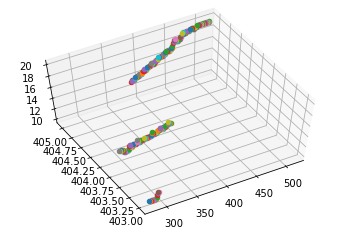

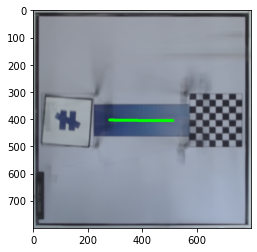

In [13]:
# Visualize
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
visual = []
for path_cnt in path_cnts:
    P = unicorn.Path(path_cnt)
    P.waypoints = path_cnt
    waypoints3D = P.generate_trajectory3D_rev2(src=gray,
                                             min_height=min_height,
                                             max_height=max_height,
                                             gradient_crop_ratio=gradient_crop_ratio,
                                             min_intensity_range=min_intensity_range)
    for waypoint in waypoints3D: ax.scatter(waypoint[0], waypoint[1], waypoint[2])
    canvas = original.copy()
    for i in range(len(path_cnt)): cv2.circle(canvas, (path_cnt[i][0], path_cnt[i][1]), 5, (0, 255, 0), -1)
    visual.append(canvas)
print(waypoints3D)
ax.view_init(azim=-120, elev=60)
plt.show()
imshow(visual[0])

In [ ]:
H = 30 # Height buffer
waypoints = [] # List of (x, y, z)
for i in range(len(Markers)):
    ### Marker ###
    (x, y) = sorted_object[2*i].center
    waypoints.append((x, y, H)) # Hold height
    if Paths[i].waypoints3D[0][2] == -1: z = H
    else: z = Paths[i].waypoints3D[0][2]
    waypoints.append((x, y, z)) # Adjust height
    H = z # update history
    ### Path ###
    for (x, y, z) in Paths[i].waypoints3D:
#         print(H)
        if z == -1: z = H # Hold height
        waypoints.append((x, y, z))
        H = z # update history
